In [1]:
#Importing Libraries
import math
import os
import numpy as np
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import random_split,  DataLoader
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandAugment
from torchsummary import summary
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, RichProgressBar
from datasets import load_dataset
import evaluate
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\sayan\anaconda3\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = torch.device('cpu')

In [3]:
# Defining general parameters
batch_size = 32
img_height = 224
img_width = 224
learning_rate = 2e-4
epochs = 10
num_classes = 3

In [4]:
# Downloading the dataset from the Hub
ds = load_dataset("fire_dataset")
ds

Resolving data files:   0%|          | 0/999 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 999
    })
})

In [8]:
#creating an empty DataFrame
import pandas as pd
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append m

C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append m

C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append m

C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:9: FutureWarning: The frame.append m

C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: Th

C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
C:\Users\sayan\AppData\Local\Temp\ipykernel_52500\2869307193.py:14: FutureWarning: Th

path     label
0          fire_dataset/fire_images\fire.532.png      fire
1  fire_dataset/non_fire_images\non_fire.163.png  non_fire
2          fire_dataset/fire_images\fire.545.png      fire
3          fire_dataset/fire_images\fire.441.png      fire
4          fire_dataset/fire_images\fire.103.png      fire
5  fire_dataset/non_fire_images\non_fire.100.png  non_fire
6          fire_dataset/fire_images\fire.312.png      fire
7          fire_dataset/fire_images\fire.734.png      fire
8          fire_dataset/fire_images\fire.310.png      fire
9          fire_dataset/fire_images\fire.263.png      fire

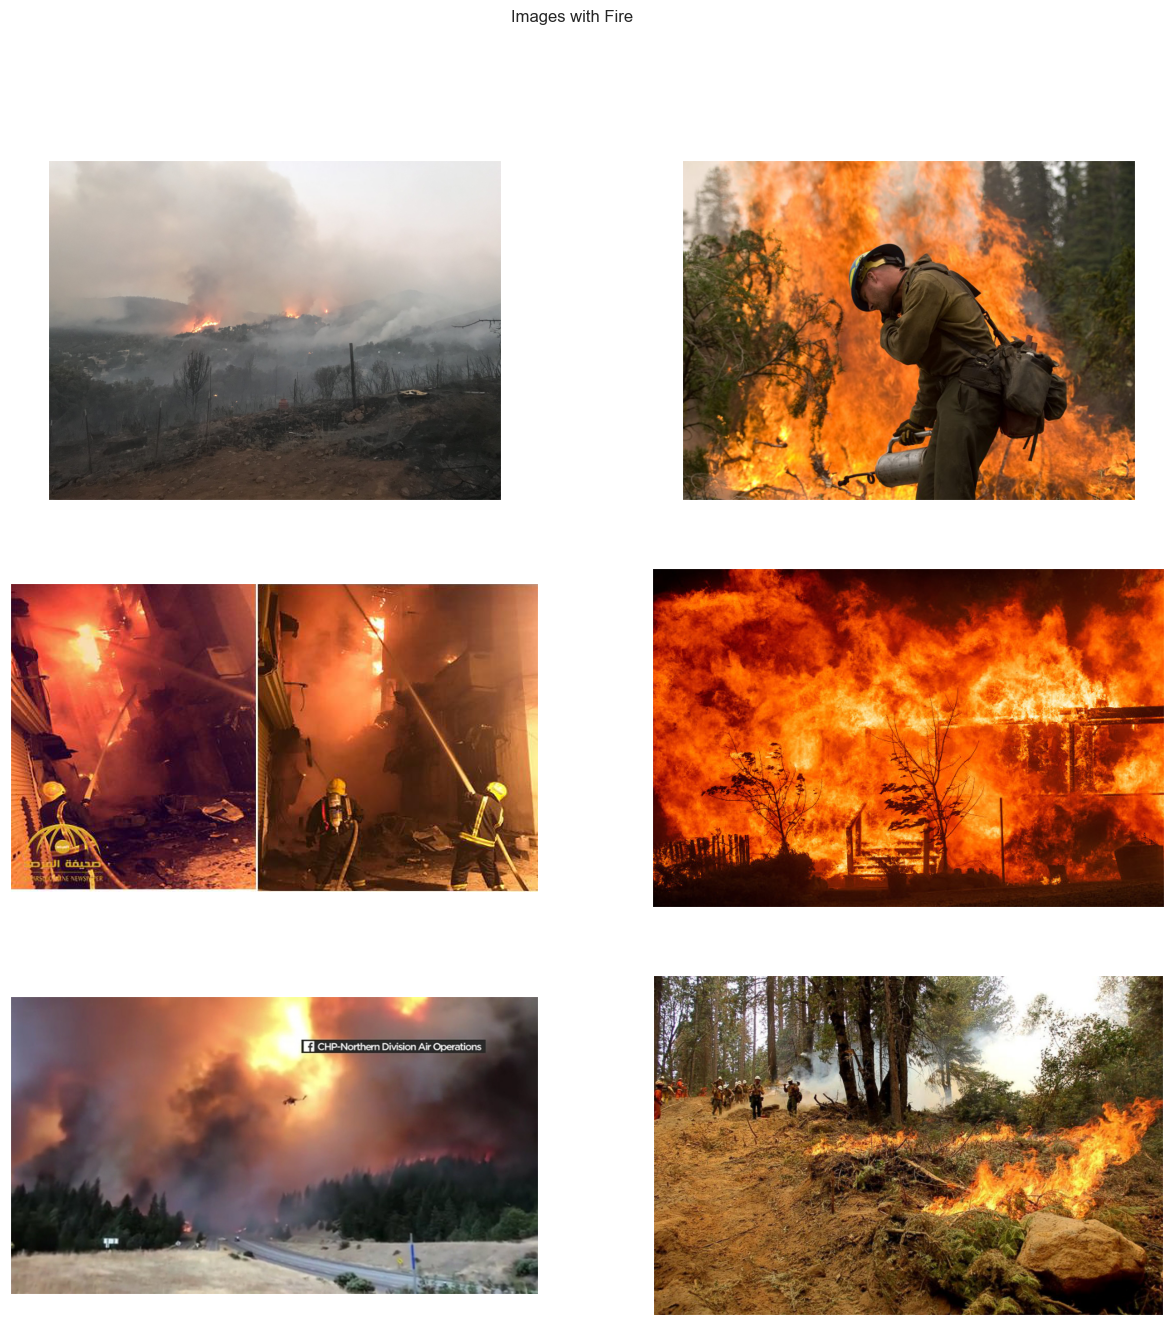

In [11]:
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
label = 'fire' #label for images with fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

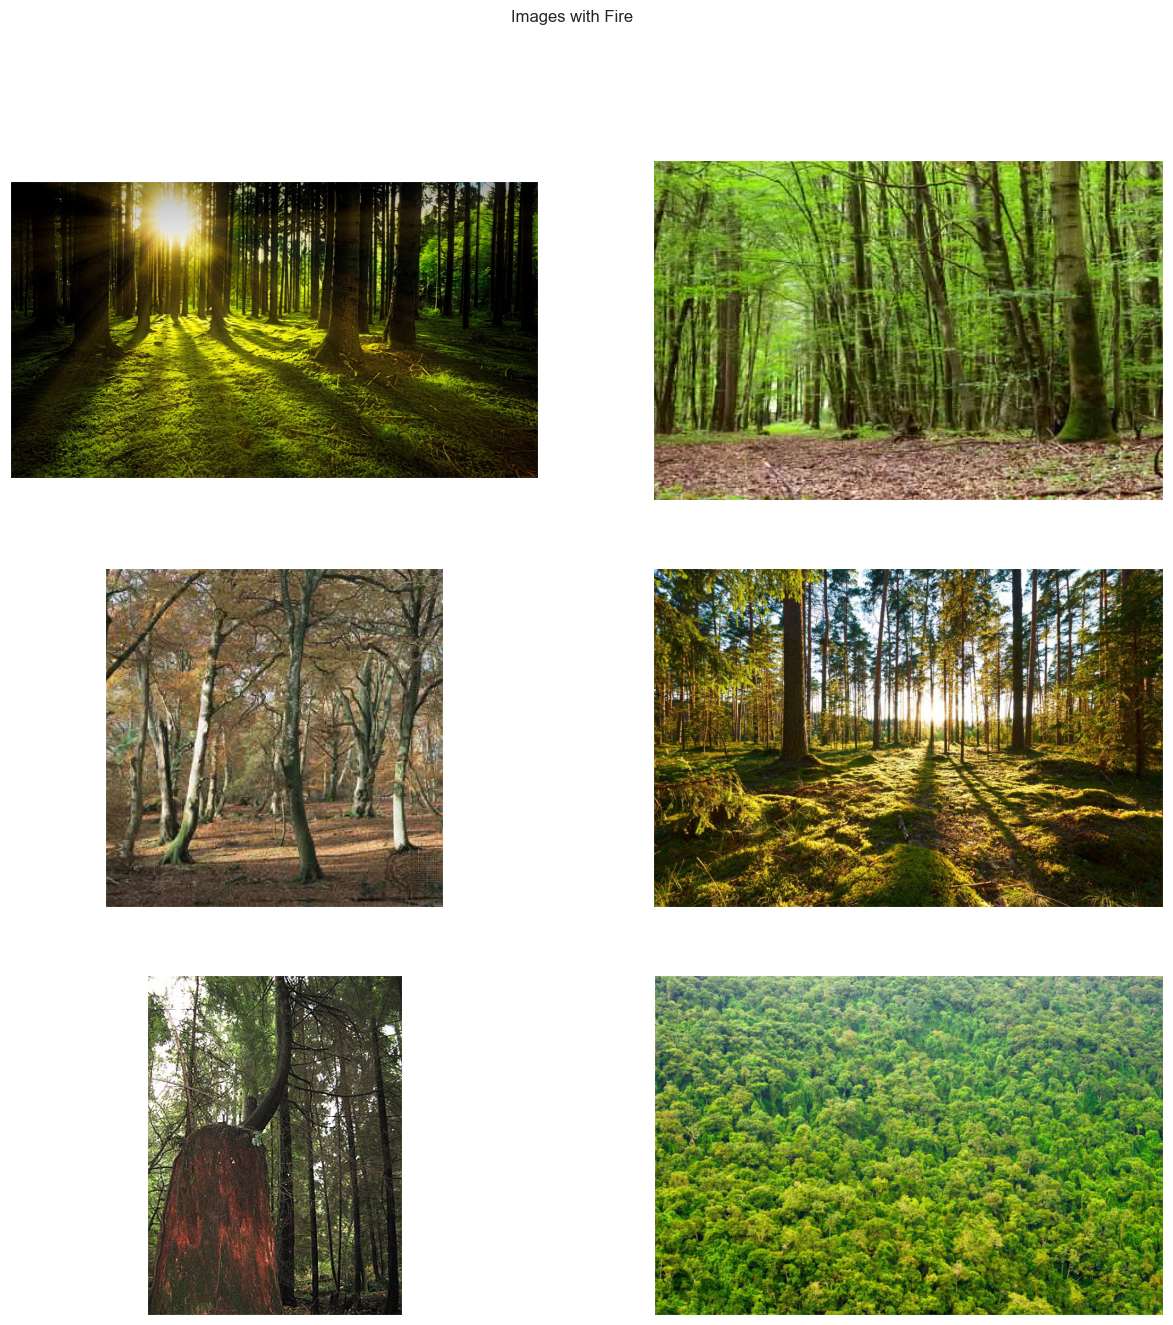

In [12]:
label = 'non_fire' #label for images without fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with nonFire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [13]:
# Define the model to use and the feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

C:\Users\sayan\anaconda3\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
# Picking up a sample from the dataset
ex = ds['train'][167]
print("Label: " + str(ex['label']))
ex['image']
# Print shape of the tensor of a sample image
sample_tensor = feature_extractor(ex['image'], return_tensors='pt')
sample_tensor['pixel_values'].shape

Label: 0


torch.Size([1, 3, 224, 224])

In [16]:
# Define a normalizer
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# Define the transformation to apply to the images from train and val samples
_train_transforms = Compose(
        [
            Resize((feature_extractor.size['width'],feature_extractor.size['height'])),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            normalize
        ]
    )

_val_transforms = Compose(
        [
            Resize((feature_extractor.size['width'],feature_extractor.size['height'])),
            ToTensor(),
            normalize
        ]
    )

# Define the actual function that applies the transformations to the samples
def train_transforms(batch):
    batch['pixel_values'] = [_train_transforms(x.convert("RGB")) for x in batch['image']]
    return batch

def val_transforms(batch):
    batch['pixel_values'] = [_val_transforms(x.convert("RGB")) for x in batch['image']]
    return batch

In [17]:
# Apply the transformations to the samples. Note that the set_transform() functions modifies in-place.
ds['train'].set_transform(train_transforms)

In [18]:
# Define the data collator
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [19]:
# Define the function that will compute precision and recall (metrics)
def compute_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    precision = metric1.compute(predictions=preds, references=labels, average="weighted")["precision"]
    recall = metric2.compute(predictions=preds, references=labels, average="weighted")["recall"]

    return {"precision": precision, "recall": recall}

In [20]:
# Load a pretrained model --> vit-base-patch16-224-in21k and define classes and labels
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = num_classes,
    id2label = {0:'Fire', 1:'Normal', 2:'Smoke'},
    label2id = {'Fire':0, 'Normal':1, 'Smoke':2})

model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [22]:
# default uses adamW optimizer
training_args = TrainingArguments(
  output_dir="./vit-fire-detection",
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_steps=50,
  num_train_epochs=epochs,

  learning_rate=learning_rate,
  weight_decay=0.01,
  adam_beta1=0.9,
  adam_beta2=0.999,
  adam_epsilon=1e-8,
  warmup_steps=100,

  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub="end", #set to "end" and call save_model()
  report_to=None,
  load_best_model_at_end=True
)

In [26]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",    # Directory where model checkpoints and logs will be saved
    overwrite_output_dir=True,     # Overwrite the content of the output directory if it already exists
    num_train_epochs=3,            # Number of training epochs
    per_device_train_batch_size=16, # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    evaluation_strategy="steps",    # "steps" or "epoch" for evaluation
    save_total_limit=3,            # Number of checkpoints to save
    logging_dir="./logs",          # Directory for storing logs
    logging_steps=500,              # Log every 500 steps
    eval_steps=1000,                # Evaluate every 1000 steps
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds["train"],
    compute_metrics=compute_metrics,
)

In [36]:
#Checking the model 
# Upload the model to the Hub to make it accesible and public
trainer.save_model()

In [40]:
from transformers import pipeline
from PIL import Image

image = Image.open("istockphoto-504424130-612x612.jpg")
pipeline = pipeline(task="image-classification", model="EdBianchi/vit-fire-detection")
predictions = pipeline(image)

C:\Users\sayan\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sayan\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [41]:
predictions


[{'score': 0.9987255930900574, 'label': 'Fire'},
 {'score': 0.0008762174984440207, 'label': 'Normal'},
 {'score': 0.00039814587216824293, 'label': 'Smoke'}]

In [43]:
from transformers import pipeline
from PIL import Image

image = Image.open("johnson-martin-zpq2DMidOY0-unsplash.jpg")
pipeline = pipeline(task="image-classification", model="EdBianchi/vit-fire-detection")
predictions = pipeline(image)

In [44]:
predictions

[{'score': 0.9988707900047302, 'label': 'Normal'},
 {'score': 0.0006163016660138965, 'label': 'Smoke'},
 {'score': 0.0005128662451170385, 'label': 'Fire'}]